In [3]:
from sklearn.datasets import make_circles


In [4]:
n_samples = 1000 
X, y = make_circles(n_samples, 
                   noise=0.03, 
                   random_state=42)

In [5]:
import pandas as pd 

In [6]:
circles = pd.DataFrame({"X1": X[:,0],
                    "X2": X[:,1],
                    "Label": y  } )
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
circles.Label.value_counts()

Label
1    500
0    500
Name: count, dtype: int64

'\n# For binary classification (y = [0, 1]):\ny = 0  →  Red color\ny = 1  →  Blue color\n\n# For 3-class classification (y = [0, 1, 2]):\ny = 0  →  Red color\ny = 1  →  Yellow color  \ny = 2  →  Blue color\n'

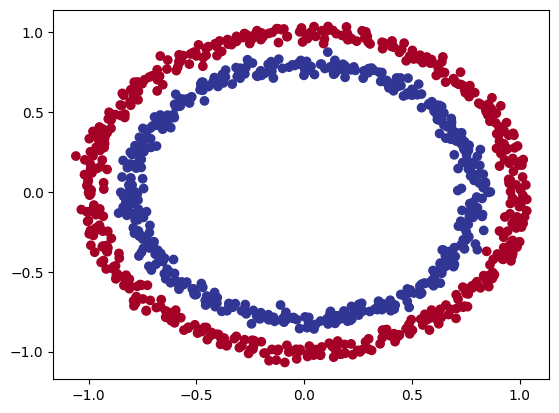

In [8]:
# Visualize with plot
import matplotlib.pyplot as plt 

plt.scatter(x=X[:,0], y=X[:,1],
            c=y,
           cmap=plt.cm.RdYlBu) # red , yellow blue
"""
# For binary classification (y = [0, 1]):
y = 0  →  Red color
y = 1  →  Blue color

# For 3-class classification (y = [0, 1, 2]):
y = 0  →  Red color
y = 1  →  Yellow color  
y = 2  →  Blue color
"""

## 1.1 Input and Output shape

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [11]:
import torch 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2.Building a model

In [14]:
import torch 
from torch import nn 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# You can also do the same as above using nn.Sequential.
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

## why not just always use nn.Sequential?
- nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.
- So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass

In [17]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.1090],
        [ 0.0950],
        [-0.0996],
        [ 0.1691],
        [-0.4889],
        [-0.4945],
        [-0.2253],
        [-0.3644],
        [-0.0828],
        [ 0.0897]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### PyTorch has two binary cross entropy implementations:

- torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
- torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).

In [18]:
# Create a loss function 
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer 
optimizer = torch.optim.SGD(params = model_0.parameters(),
                           lr=0.1)

In [19]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


## 3. Train Model 

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [20]:
y_logits = model_0(X_test.to(device))[:5] # the raw outputs of our model are often referred to as logits.
y_logits 

tensor([[ 0.1090],
        [ 0.0950],
        [-0.0996],
        [ 0.1691],
        [-0.4889]], device='cuda:0', grad_fn=<SliceBackward0>)

In [21]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5272],
        [0.5237],
        [0.4751],
        [0.5422],
        [0.3801]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# Get rid of extra dimension
y_preds.squeeze()

tensor([1., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [24]:
torch.manual_seed(42)

# set the n of epochs 
epochs = 100 

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training 
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # The raw, unnormalized outputs of the model, usually the direct output of the last linear (fully connected) layer.
    y_pred = torch.round(torch.sigmoid(y_logits)) # The final predictions of the model, which can mean: Probabilities (after applying softmax or sigmoid), etc

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. loss backward
    loss.backward()

    # 4. Optimizer step 
    optimizer.step()

    # 5. Optimizer zero grad
    optimizer.zero_grad()

    ### Testing 
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                              y_pred=test_pred)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70359, Accuracy: 49.00% | Test loss: 0.70596, Test acc: 45.00%
Epoch: 10 | Loss: 0.69984, Accuracy: 49.00% | Test loss: 0.70244, Test acc: 48.00%
Epoch: 20 | Loss: 0.69786, Accuracy: 48.50% | Test loss: 0.70040, Test acc: 50.00%
Epoch: 30 | Loss: 0.69661, Accuracy: 48.75% | Test loss: 0.69898, Test acc: 51.50%
Epoch: 40 | Loss: 0.69574, Accuracy: 49.00% | Test loss: 0.69792, Test acc: 52.50%
Epoch: 50 | Loss: 0.69511, Accuracy: 49.38% | Test loss: 0.69709, Test acc: 51.50%
Epoch: 60 | Loss: 0.69463, Accuracy: 49.62% | Test loss: 0.69643, Test acc: 51.50%
Epoch: 70 | Loss: 0.69427, Accuracy: 49.62% | Test loss: 0.69590, Test acc: 51.00%
Epoch: 80 | Loss: 0.69400, Accuracy: 49.62% | Test loss: 0.69548, Test acc: 51.50%
Epoch: 90 | Loss: 0.69380, Accuracy: 49.62% | Test loss: 0.69514, Test acc: 51.50%


## 4. Make predictions and evaluate the model

In [25]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)



In [26]:
# from helper_fucntions import plot_predictions, plot_decision_boundary
from helper_functions import plot_predictions, plot_decision_boundary

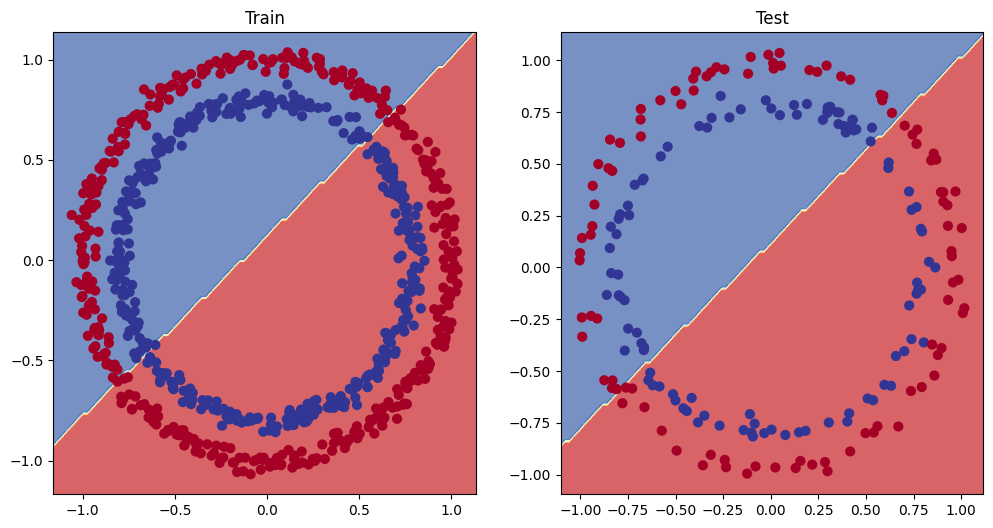

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # row, col, index
plt.title("Train")
plot_decision_boundary(model_0,X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model(rom a model perspective)
<img src="Imporving_a_model.png" style="border: 5px solid black; border-radius: 10px;" />

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# Create loss function and optimizer 
loss_fn = nn.BCEWithLogitsLoss() # does not require sigmoid 
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)

epochs = 1000 

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training 
    y_logits = model1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_preds)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    ### Testing
    model1.eval()
    with torch.inference_mode():
        test_logits = model1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_preds)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


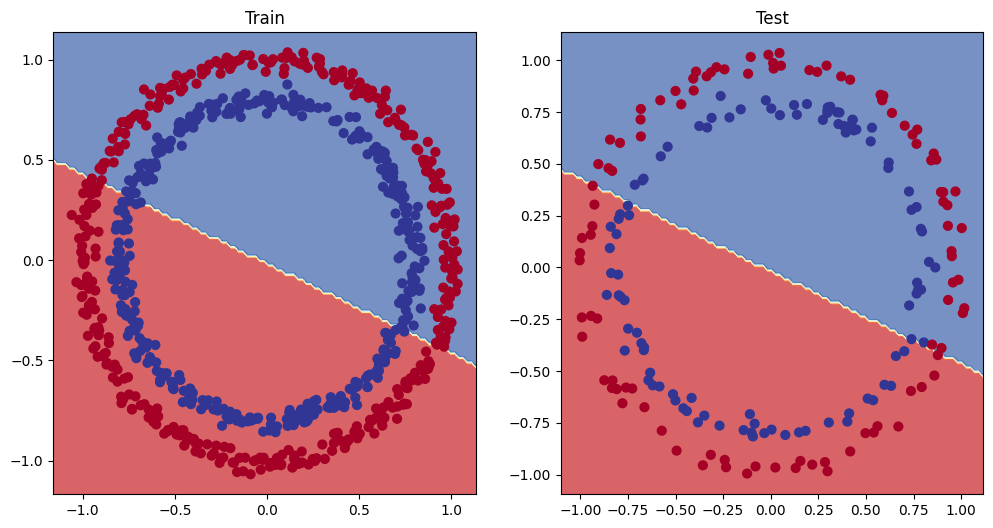

In [31]:
# Visualize 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)


## 6.2 Building a model with non-linearity

- One of the most common and best performing is ReLU) (rectified linear-unit, torch.nn.ReLU()).

In [32]:
# Build model with non-linear activation function
from torch import nn 
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model3 = CircleModelV2().to(device)
model3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [33]:
# set up loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [34]:
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training 
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Cal loss and acc 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    ### Testing 
    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Cal loss and acc for test_data
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [35]:
# Make predition 
model3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model3(X_test)))

y_preds[:10], y_test[:10]

(tensor([[1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

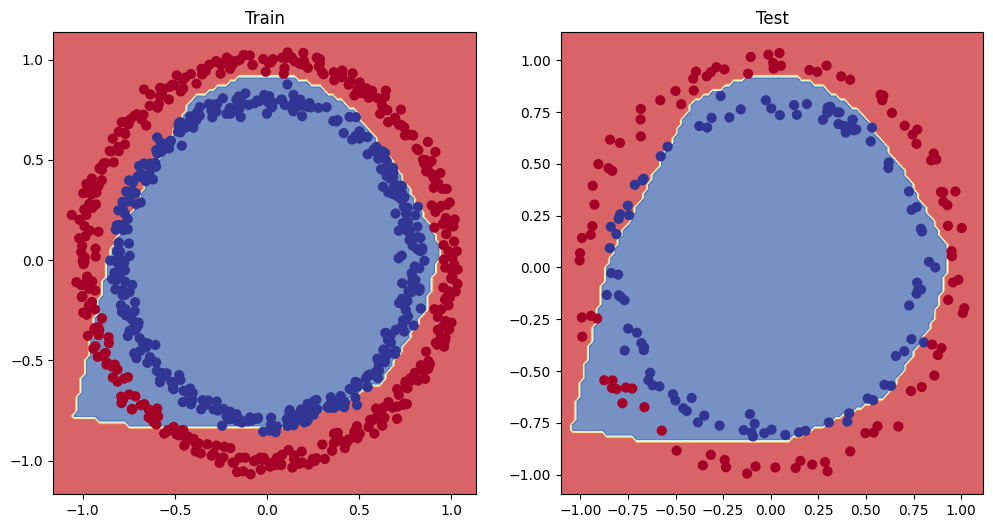

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # row, col, index
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2) # row, col, index
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)


## 7. Replicating non-linear activation functions

In [37]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

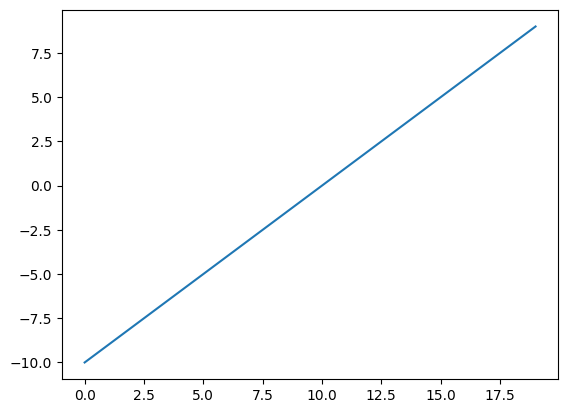

In [38]:
plt.plot(A)

In [39]:
# Create ReLU function by hand 
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

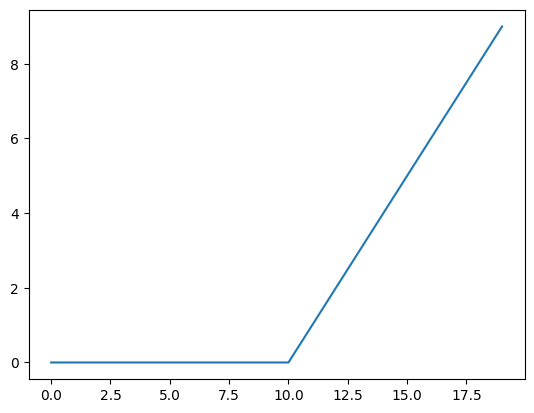

In [40]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [41]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

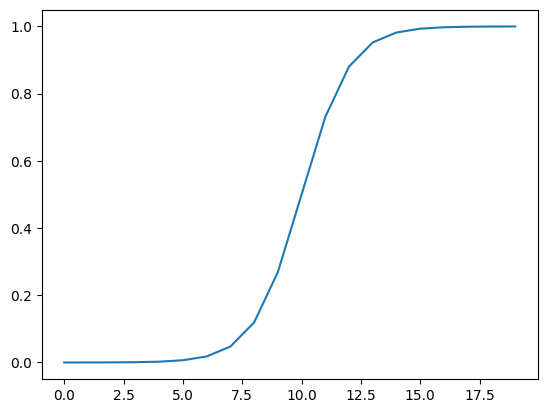

In [42]:

# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Putting things together by building a multi-class PyTorch model

### 8.1 Creating multi-class classification data

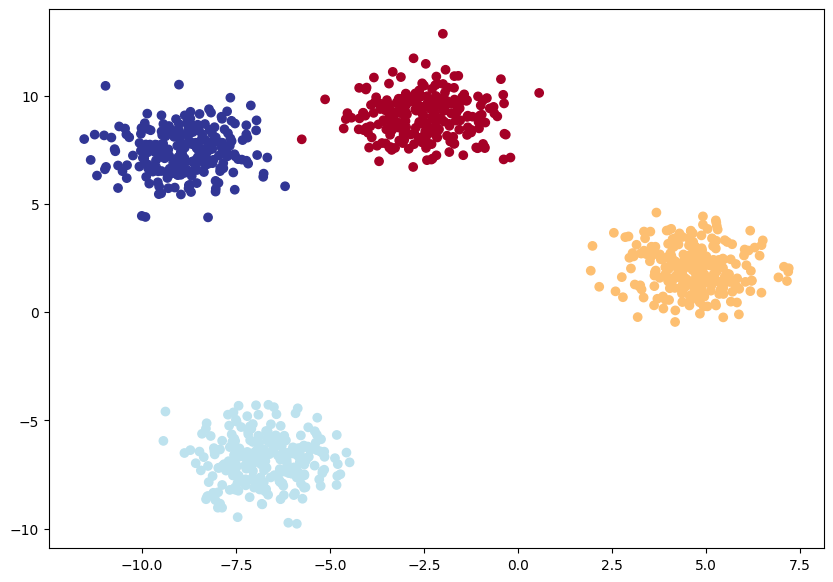

In [43]:
import torch 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2 
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           random_state=RANDOM_SEED) 

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                       random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [45]:
from  torch import nn 

# Build model 
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model4 = BlobModel(input_features=NUM_FEATURES, 
                   output_features=NUM_CLASSES).to(device)
model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [46]:
#  Create loss and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.1)

In [47]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
y_logits = model4(X_blob_train.to(device))
y_logits[:5]

tensor([[-1.2096, -0.5905, -1.3977, -0.6999],
        [ 0.2225, -1.5206,  0.0469,  1.1367],
        [ 2.6882,  0.8213,  3.1033,  1.3287],
        [ 2.0801,  0.4201,  2.3750,  1.1485],
        [ 0.4390, -1.3168,  0.3150,  1.1549]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [48]:
y_logits.shape

torch.Size([800, 4])

In [49]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2096, -0.5905, -1.3977, -0.6999],
        [ 0.2225, -1.5206,  0.0469,  1.1367],
        [ 2.6882,  0.8213,  3.1033,  1.3287],
        [ 2.0801,  0.4201,  2.3750,  1.1485],
        [ 0.4390, -1.3168,  0.3150,  1.1549]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1869, 0.3471, 0.1549, 0.3111],
        [0.2218, 0.0388, 0.1861, 0.5533],
        [0.3418, 0.0528, 0.5176, 0.0878],
        [0.3416, 0.0650, 0.4588, 0.1346],
        [0.2438, 0.0421, 0.2153, 0.4988]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [50]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1869, 0.3471, 0.1549, 0.3111], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [51]:
# Fit the model
torch.manual_seed(42)

# Set the number of epochs 
epochs = 100

# Put data to target device 
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training 
    model4.train()

    y_logits = model4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred =y_pred)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    ### Testing 
    model4.eval()
    with torch.inference_mode():
        test_logits = model4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Cal test loss and acc
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, 
                              y_pred=test_pred)
        if epoch % 10 == 0:        
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.03702, Acc: 68.50% | Test Loss: 0.56405, Test Acc: 99.00%
Epoch: 10 | Loss: 0.11087, Acc: 99.88% | Test Loss: 0.10004, Test Acc: 100.00%
Epoch: 20 | Loss: 0.04924, Acc: 99.88% | Test Loss: 0.04515, Test Acc: 100.00%
Epoch: 30 | Loss: 0.03032, Acc: 99.88% | Test Loss: 0.02747, Test Acc: 100.00%
Epoch: 40 | Loss: 0.02171, Acc: 99.88% | Test Loss: 0.01930, Test Acc: 100.00%
Epoch: 50 | Loss: 0.01691, Acc: 99.88% | Test Loss: 0.01471, Test Acc: 100.00%
Epoch: 60 | Loss: 0.01389, Acc: 99.88% | Test Loss: 0.01182, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01182, Acc: 99.88% | Test Loss: 0.00985, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01033, Acc: 99.88% | Test Loss: 0.00843, Test Acc: 100.00%
Epoch: 90 | Loss: 0.00920, Acc: 99.88% | Test Loss: 0.00736, Test Acc: 100.00%


In [52]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(test_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


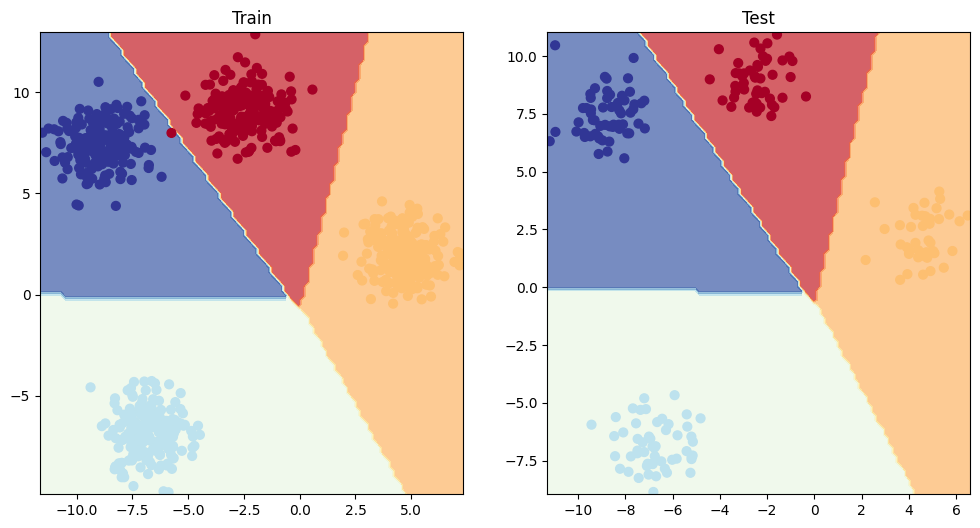

In [53]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

- Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out TorchMetrics, especially the TorchMetrics classification section.



In [54]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Cal acc 
torchmetrics_accuracy(y_preds, y_blob_test)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Gaming\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchmetrics\utilities\imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


tensor(1., device='cuda:0')